In [6]:
import diff_classifier.aws as aws
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from scipy.optimize import leastsq

In [2]:
filename = 'catwalk_data.csv'
folder = 'ferret_tracking'

aws.download_s3('{}/{}'.format(folder, filename), filename, bucket_name='ccurtis.data')

In [27]:
ferret_data = pd.read_csv(filename)
ferret_data = ferret_data.sort_values(by=['X'])
length = ferret_data.shape[0]

In [28]:
length

16

In [44]:
def fit_sine(x, y, guess_freq=1/150):

    guess_mean = np.mean(y)
    guess_std = 3*np.std(y)/(2**0.5)/(2**0.5)
    guess_phase = 0
    guess_freq = 1/150
    guess_amp = 1

    # we'll use this to plot our first estimate. This might already be good enough for you
    data_first_guess = guess_std*np.sin(x+guess_phase) + guess_mean

    # Define the function to optimize, in this case, we want to minimize the difference
    # between the actual data and our "guessed" parameters
    optimize_func = lambda z: z[0]*np.sin(z[1]*x+z[2]) + z[3] - y
    est_amp, est_freq, est_phase, est_mean = leastsq(optimize_func, [guess_amp, guess_freq, guess_phase, guess_mean])[0]

    # recreate the fitted curve using the optimized parameters
    data_fit = est_amp*np.sin(est_freq*x+est_phase) + est_mean

    # recreate the fitted curve using the optimized parameters

    fine_t = np.arange(0,max(x),0.1)
    data_fit=est_amp*np.sin(est_freq*fine_t+est_phase)+est_mean
    
    return fine_t, data_fit, est_amp, est_freq

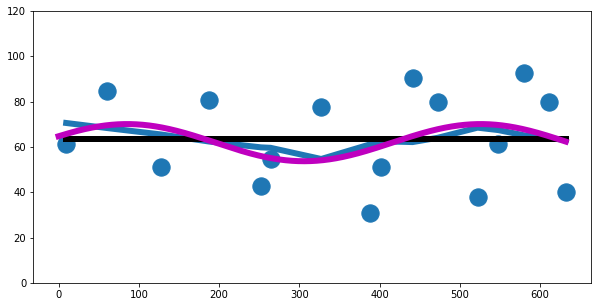

In [57]:
x = ferret_data['X']
y = ferret_data['Y']
fine_t, data_fit, est_amp, est_freq = fit_sine(x, y, guess_freq=1/100)

lowess = sm.nonparametric.lowess
ymid = lowess(y, x, frac=0.5)
yavg = np.convolve(y, np.ones((length,))/length, mode='same')

plt.figure(figsize=(10, 5))
plt.scatter(x, y, s=300)
plt.plot(x, ymid[:, 1], linewidth=6)
plt.plot(x, np.mean(y)*np.ones((length,)), 'k', linewidth=6)
plt.plot(fine_t, data_fit, 'm', linewidth=6)
#plt.plot(x, yavg, 'k', linewidth=6)
plt.ylim(0, 120)
plt.show()

In [58]:
ystd = np.round(np.std(y), 2)
yrange = np.round(np.ptp(y), 2)
rsd = 100*np.round(ystd/np.mean(y), 2)

print('Deviation from midline: {}'.format(ystd))
print('Range in y: {}'.format(yrange))
print('Percent deviation from midline: {}'.format(rsd))
print('Fit amplitude: {}'.format(np.abs(np.round(est_amp, 2))))
print('Fit period: {}'.format(np.round(1/est_freq, 2)))

Deviation from midline: 19.61
Range in y: 61.54
Percent deviation from midline: 31.0
Fit amplitude: 8.2
Fit period: 70.09
